In [128]:
import os
import random
import shutil

import numpy as np
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib
from sklearn.metrics import confusion_matrix
from plotutils import plot_confusion_matrix, plot_images

# Cats and dogs with MobileNets

## Comparing MobileNets to other models
To give a quick comparison in regards to size, the size of the full VGG16 network on disk is about 553 megabytes. The size of one of the currently largest MobileNets is about 17 megabytes, so that is a huge difference, especially when you think about deploying a model to a mobile app or running it in the browser.

| Model      | Size     | Parameters    |
| ---------- | -------- | ------------- |
| VGG16      | `553 MB` | `138,000,000` |
| Mobile Net | `17 MB`  | `4,200,000`   |

This vast size difference is due to the number of parameters within these networks. For example, VGG16 has 138 million parameters, while the 17 megabyte MobileNet we just mentioned has only 4.2 million.

### GPU setup


In [129]:
print("Built with CUDA: ", tf.test.is_built_with_cuda())
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU available", len(gpus))
tf.config.experimental.set_memory_growth(gpus[0], True)

Built with CUDA:  True
Num GPU available 1


## MobileNet model building

In [130]:
mobile = tf.keras.applications.mobilenet.MobileNet()

## Image preparation


In [131]:

def prepare_image(file_path):
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)


In [132]:
full_dir = 'data/full'
split_dir = 'data/split'
train_dir = f'{split_dir}/train'
valid_dir = f'{split_dir}/valid'
test_dir = f'{split_dir}/test'

def split_images():

    script_folder = globals()['_dh'][0]
    print('Siamo nella cartella:', script_folder)

    if os.path.isdir(f'{train_dir}/0') is False:
        print('Cartella con immagini suddivise non trovata, vengono create le immagini.')

        # Da 'data' faro' tutte le operazioni senza spostarmi
        # os.chdir(script_folder)
        # os.chdir('data')

        # Copio tutte le immagini originali per evitare di rovinare il dataset
        shutil.copytree(full_dir, train_dir)
        os.makedirs(valid_dir)
        os.makedirs(test_dir)

        # for current_dir in os.listdir(train_dir):
        #     print('Directory: ', current_dir)
        for directory in os.listdir(train_dir):
            cur_dir = f'{train_dir}/{directory}'
            os.makedirs(f'{valid_dir}/{directory}')
            os.makedirs(f'{test_dir}/{directory}')
            valid_samples = random.sample(os.listdir(cur_dir), 30)
            for sample in valid_samples:
                shutil.move(f'{cur_dir}/{sample}', f'{valid_dir}/{directory}/{sample}')

            test_samples = random.sample(os.listdir(cur_dir), 5)
            for sample in test_samples:
                shutil.move(f'{train_dir}/{directory}/{sample}', f'{test_dir}/{directory}/{sample}')

        # Ritorno nella cartella iniziale
        # os.chdir(script_folder)
    else:
        print('Cartella con immagini suddivise trovata, salto la creazione')

split_images()

Siamo nella cartella: C:\Workspace\keras-deeplizard\sign-language
Cartella con immagini suddivise trovata, salto la creazione


## Batch creation


In [133]:
preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
target_size = (224,224)
batch_size = 10

train_batches = ImageDataGenerator(preprocessing_function=preprocessing_function).flow_from_directory(
    directory=train_dir,
    target_size=target_size,
    batch_size=batch_size
)
valid_batches = ImageDataGenerator(preprocessing_function=preprocessing_function).flow_from_directory(
    directory=valid_dir,
    target_size=target_size,
    batch_size=batch_size
)
# Non vogliamo che il test_batch sia mescolato perchè vogliamo potervi accedere quando facciamo la
# rappresentazione grafica tramite confusion matrix
test_batches = ImageDataGenerator(preprocessing_function=preprocessing_function).flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


## Modify model

In [134]:

mobile.summary()
# Il 6 non è un numero magico ma è fatto a tentativi, quindi un po' lo è
x = mobile.layers[-6].output
# La x passata alla fine segue l'approccio funzionale
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

# Il 23 non è un numero magico ma è fatto a tentativi, quindi un po' lo è
for layer in model.layers[:-23]:
    layer.trainable = False



Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

## Modello modificato

In [135]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

## Train del modello


In [136]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Usare ~30 epochs per risultati migliori
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)


Epoch 1/10
172/172 - 14s - loss: 0.6708 - accuracy: 0.7973 - val_loss: 0.4274 - val_accuracy: 0.8700
Epoch 2/10
172/172 - 7s - loss: 0.1230 - accuracy: 0.9813 - val_loss: 0.1053 - val_accuracy: 0.9733
Epoch 3/10
172/172 - 7s - loss: 0.0626 - accuracy: 0.9936 - val_loss: 0.1077 - val_accuracy: 0.9700
Epoch 4/10
172/172 - 7s - loss: 0.0334 - accuracy: 0.9982 - val_loss: 0.0620 - val_accuracy: 0.9733
Epoch 5/10
172/172 - 7s - loss: 0.0200 - accuracy: 0.9994 - val_loss: 0.0494 - val_accuracy: 0.9867
Epoch 6/10
172/172 - 7s - loss: 0.0171 - accuracy: 0.9988 - val_loss: 0.0463 - val_accuracy: 0.9833
Epoch 7/10
172/172 - 7s - loss: 0.0116 - accuracy: 0.9994 - val_loss: 0.0449 - val_accuracy: 0.9867
Epoch 8/10
172/172 - 7s - loss: 0.0144 - accuracy: 0.9977 - val_loss: 0.0545 - val_accuracy: 0.9833
Epoch 9/10
172/172 - 7s - loss: 0.0141 - accuracy: 0.9982 - val_loss: 0.0440 - val_accuracy: 0.9800
Epoch 10/10
172/172 - 7s - loss: 0.0164 - accuracy: 0.9982 - val_loss: 0.0614 - val_accuracy: 0.976

## Predict


In [137]:
predictions = model.predict(x=test_batches, verbose=0)

In [138]:
np.round(predictions)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [139]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [140]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


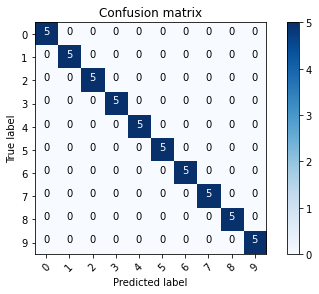

In [141]:
cm_plot_labels = test_batches.class_indices.keys()
plot_confusion_matrix(cm, classes=cm_plot_labels, title="Confusion matrix")